# NimbRoNet-v3

Illustrating the NimbRoNet-v3 model for real-time detection, segmentation and robot pose estimation on the soccer field

In [58]:
import os
import torch

import data.data_utils as data_utils
from data.load_data import build_data_loader
from data import ConfigDatasetUnlabelled, PoseDataset

from lib.config import Config
import lib.postprocessing as postprocessing
import lib.setup_model as setup_model
import lib.visualizations as visualizations

from CONFIG import CONFIG

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading Data

In [14]:
datapath = CONFIG["paths"]["data_path"]
resources_path = os.path.join(os.getcwd(), "..", "resources")
img_path = os.path.join(datapath, "blob", "dataset")

dataset = ConfigDatasetUnlabelled(
        config=os.path.join(resources_path, "test_xs7.json"),
        path=os.path.join(datapath, "blob", "dataset"),
        img_size=(540, 960),
        augmentations={},
        use_augmentations=False
    )

In [15]:

loader = build_data_loader(dataset, batch_size=6, shuffle=False)

## Load Pretrained Model 

In [17]:
exp_path = os.path.join("..", "experiments", "nimbronetV3", "test_01")
model_name = "checkpoint_epoch_70.pth"

cfg = Config(exp_path)
exp_params = cfg.load_exp_config_file()

In [18]:
model = setup_model.setup_model(model_params=exp_params["model"])

In [19]:
checkpoint_path = os.path.join(exp_path, "models", model_name)
model = setup_model.load_checkpoint(
        checkpoint_path=checkpoint_path,
        model=model,
        only_model=True
    )
model = model.eval()

## Inference

In [24]:
iterator = iter(loader)
for i in range(1):
    images, metas = next(iterator) 

In [29]:
out_model = model(images)

detections = out_model["detections"]
segmentation = out_model["segmentation"]
pose_preds = {k: out_model[k] for k in ["heatmaps_hr", "heatmaps_lr", "limbs_lr"]}

## Visualizations

### Object Detection and Segmentation

In [46]:
filtered_preds = postprocessing.filter_heatmaps(
        heatmaps=detections,
        kernel_size=exp_params["evaluation"]["kernel_size"],
        heatmap_thr=exp_params["evaluation"]["heatmap_thr"]
    )
pred_kpts, _ = postprocessing.get_kpt_from_heatmaps(
        heatmaps=filtered_preds,
        kernel_size=exp_params["evaluation"]["kernel_size"],
        peak_thr=exp_params["evaluation"]["peak_thr"]
    )
filtered_pred_kpts = postprocessing.kpt_distance_nms(pred_kpts, dist_thr=exp_params["evaluation"]["filter_thr"])

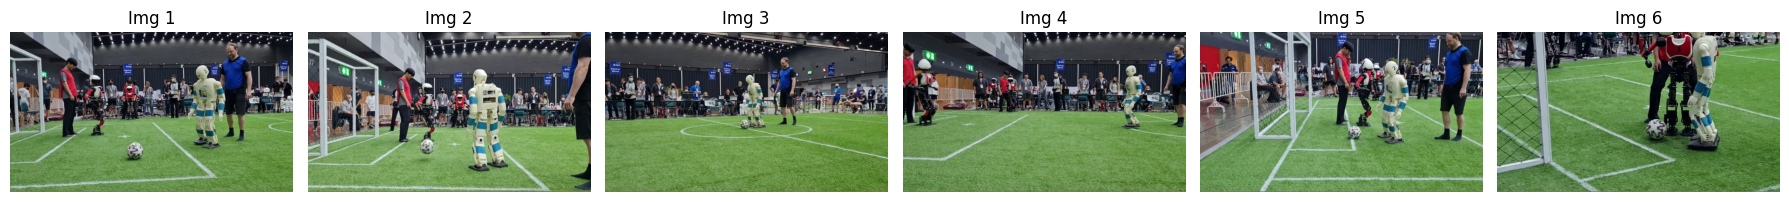

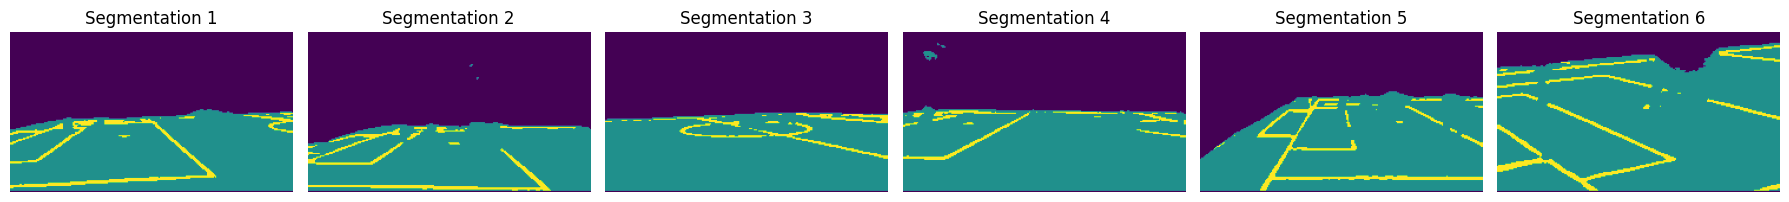

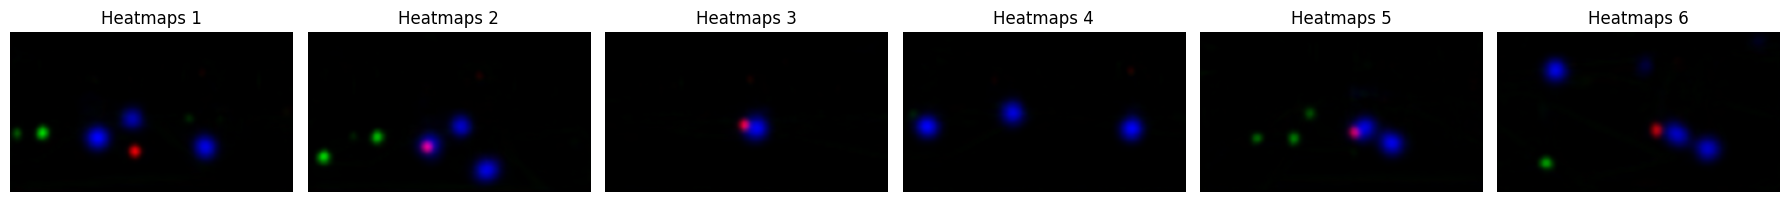

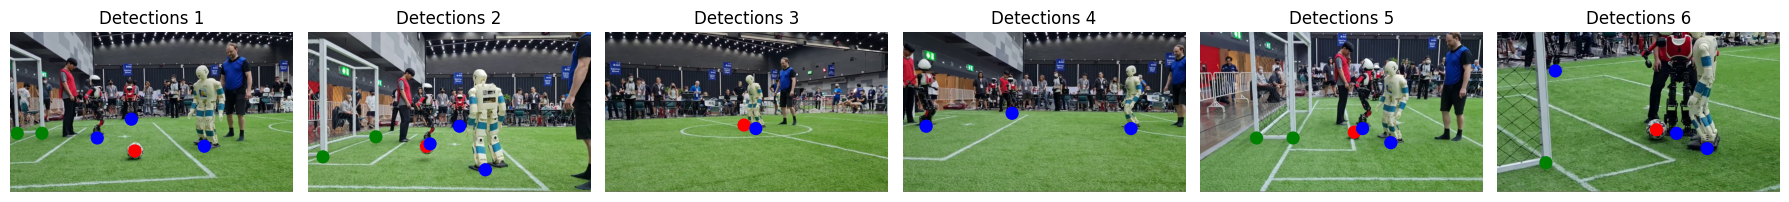

In [47]:
# images
unnorm_imgs = data_utils.unnorm_img(images)
_ = visualizations.visualize_sequence(
    unnorm_imgs,
    n_cols=6,
    titles=[f"Img {i+1}" for i in range(6)]
)

# semgentation
seg_preds = segmentation.argmax(dim=1, keepdim=True)
_ = visualizations.visualize_sequence(
    seg_preds / 3,
    n_cols=6,
    titles=[f"Segmentation {i+1}" for i in range(6)]
)

# heatmaps and detections
_ = visualizations.visualize_sequence(
    detections.clamp(0, 1),
    n_cols=6,
    titles=[f"Heatmaps {i+1}" for i in range(6)]
)
fig, ax, im = visualizations.visualize_sequence(
    unnorm_imgs,
    n_cols=6,
    titles=[f"Detections {i+1}" for i in range(6)]
)
# Locations
colors = ["r", "g", "b"]
for i in range(6):
    for c in range(3):
        for kpt in filtered_pred_kpts[i, c]:
            if kpt[0] < 0 or kpt[1] < 0:
                continue
            circle = plt.Circle((kpt * 4).tolist(), 20, color=colors[c])
            ax[i].add_patch(circle)

### Pose Estimation Outputs

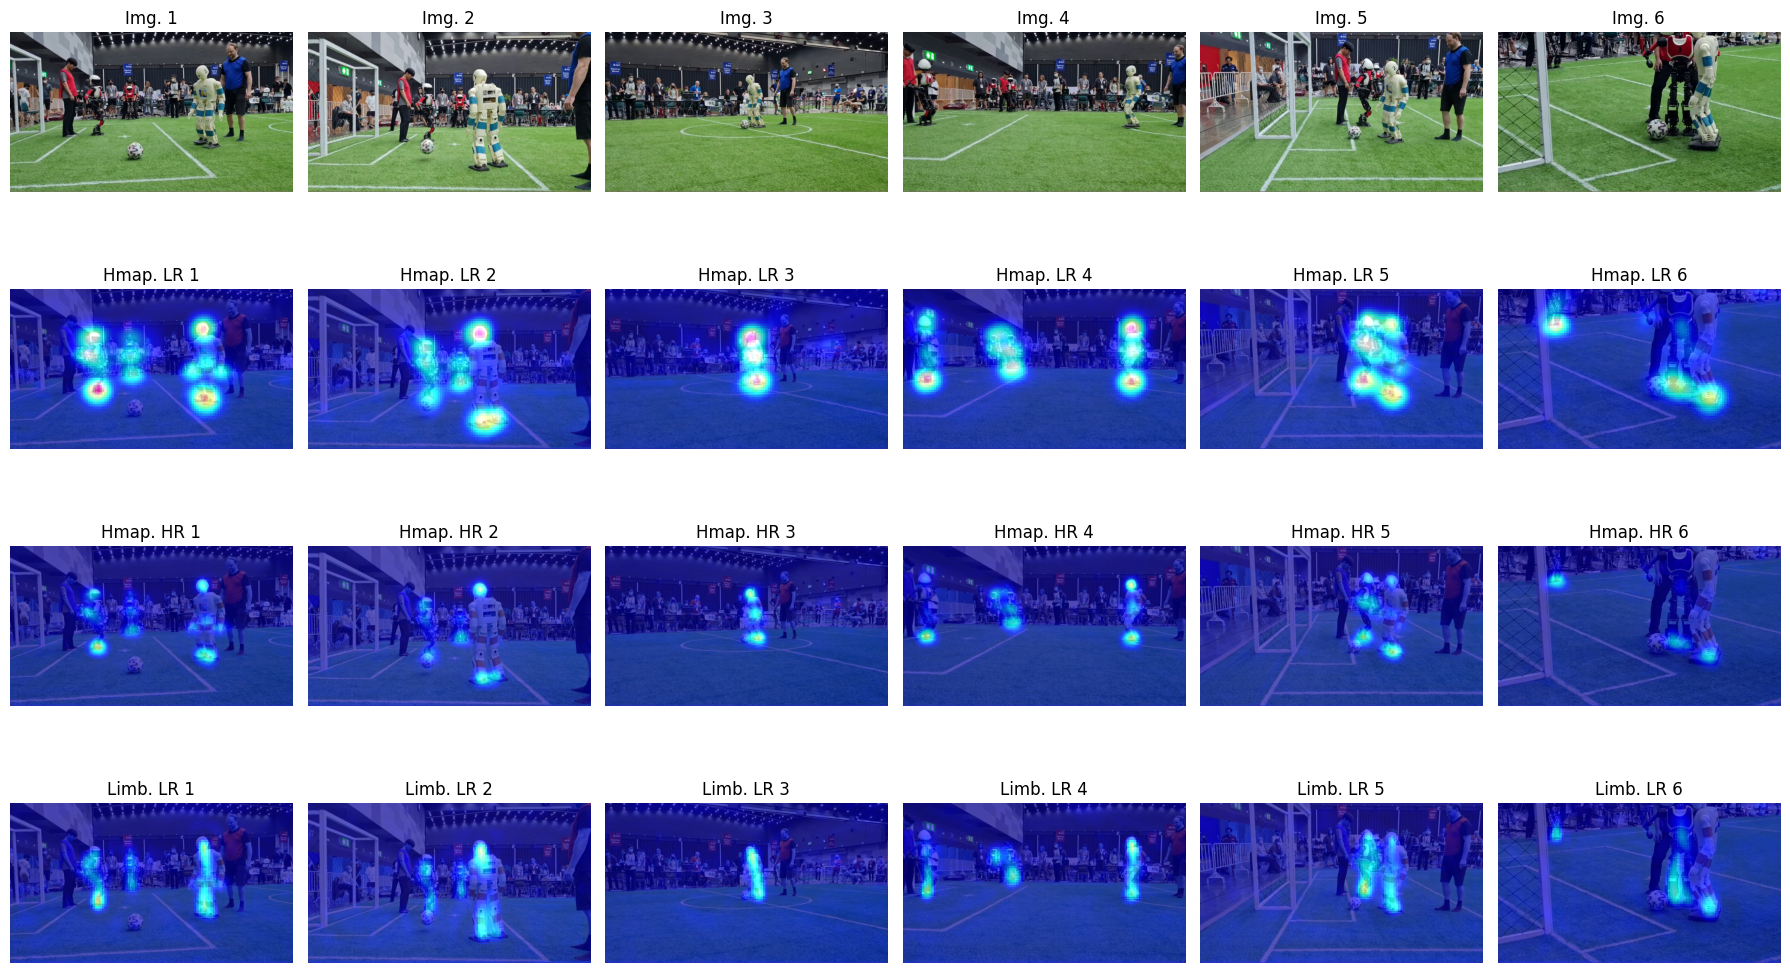

In [30]:
fig, ax, im = visualizations.visualize_pose_predictions(
    imgs=images,
    targets=None,
    preds=pose_preds,
    n_cols=6,
)

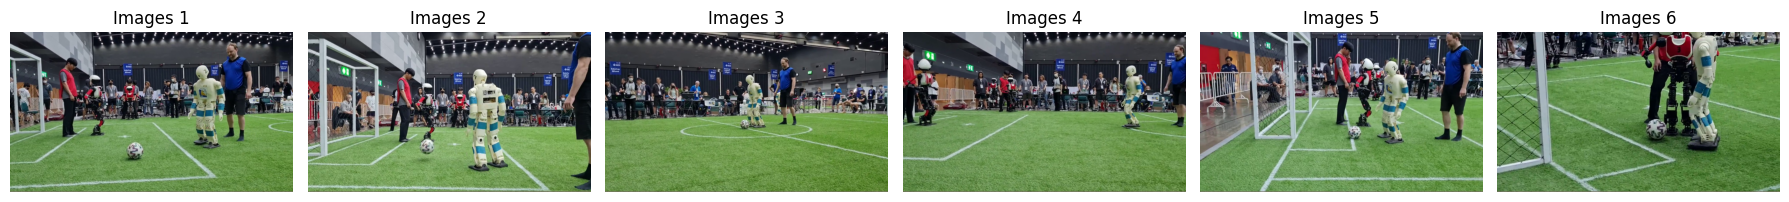

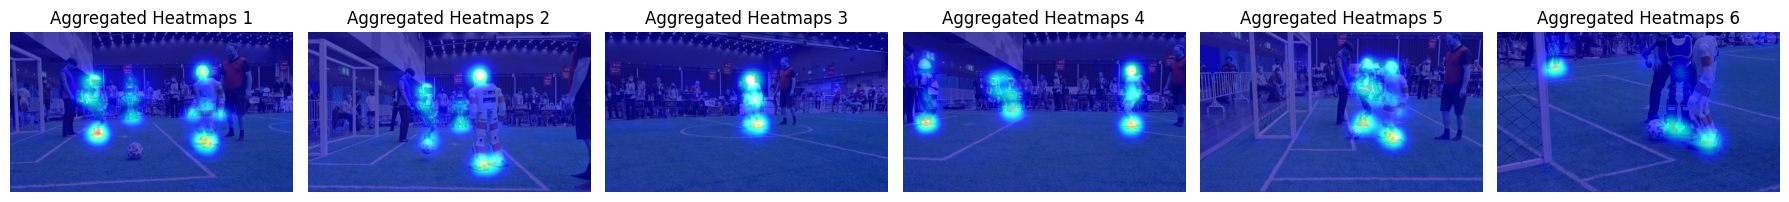

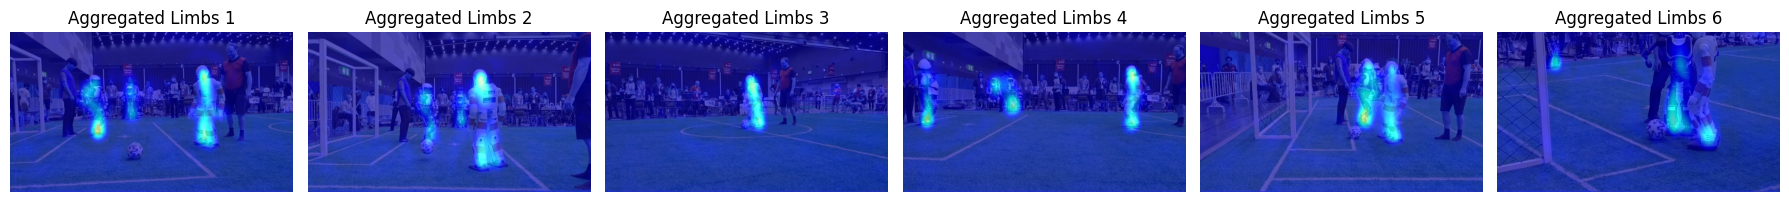

In [50]:
heatmaps_hr = pose_preds["heatmaps_hr"]
heatmaps_lr = pose_preds['heatmaps_lr']
limbs_lr = pose_preds['limbs_lr']
n_kpts = heatmaps_hr.shape[1] - 1

fused_hmaps = postprocessing.aggregate_multi_scale_hmaps(lr_hmaps=heatmaps_lr, hr_hmaps=heatmaps_hr, num_kpts=n_kpts)
hr_size = (heatmaps_hr.shape[-2], heatmaps_hr.shape[-1])
fused_limbs = postprocessing.aggregate_multi_scale_hmaps(lr_hmaps=limbs_lr, hr_size=hr_size)

unnorm_imgs = data_utils.unnorm_img(images)
fused_heat_imgs = torch.stack([visualizations.overlay_pose_heatmaps(
    unnorm_imgs[i],
    fused_hmaps[i]
)[0] for i in range(6)])
fused_limb_imgs = torch.stack([visualizations.overlay_pose_heatmaps(
    unnorm_imgs[i],
    fused_limbs[i]
)[0] for i in range(6)])
_ = visualizations.visualize_sequence(
    unnorm_imgs[:6],
    n_cols=6,
    titles=[f"Images {i+1}" for i in range(6)]
)
_ = visualizations.visualize_sequence(
    fused_heat_imgs,
    n_cols=6,
    titles=[f"Aggregated Heatmaps {i+1}" for i in range(6)]
)
_ = visualizations.visualize_sequence(
    fused_limb_imgs,
    n_cols=6,
    titles=[f"Aggregated Limbs {i+1}" for i in range(6)]
)


In [60]:
results, dets = postprocessing.group_poses(
    heatmaps=fused_hmaps,
    limb_heatmaps=fused_limbs,
    limbs=np.array(PoseDataset.LIMBS),
    cfg=None,
    nms_kernel=3,
    max_num_dets=8,
    det_thr=0.1
)

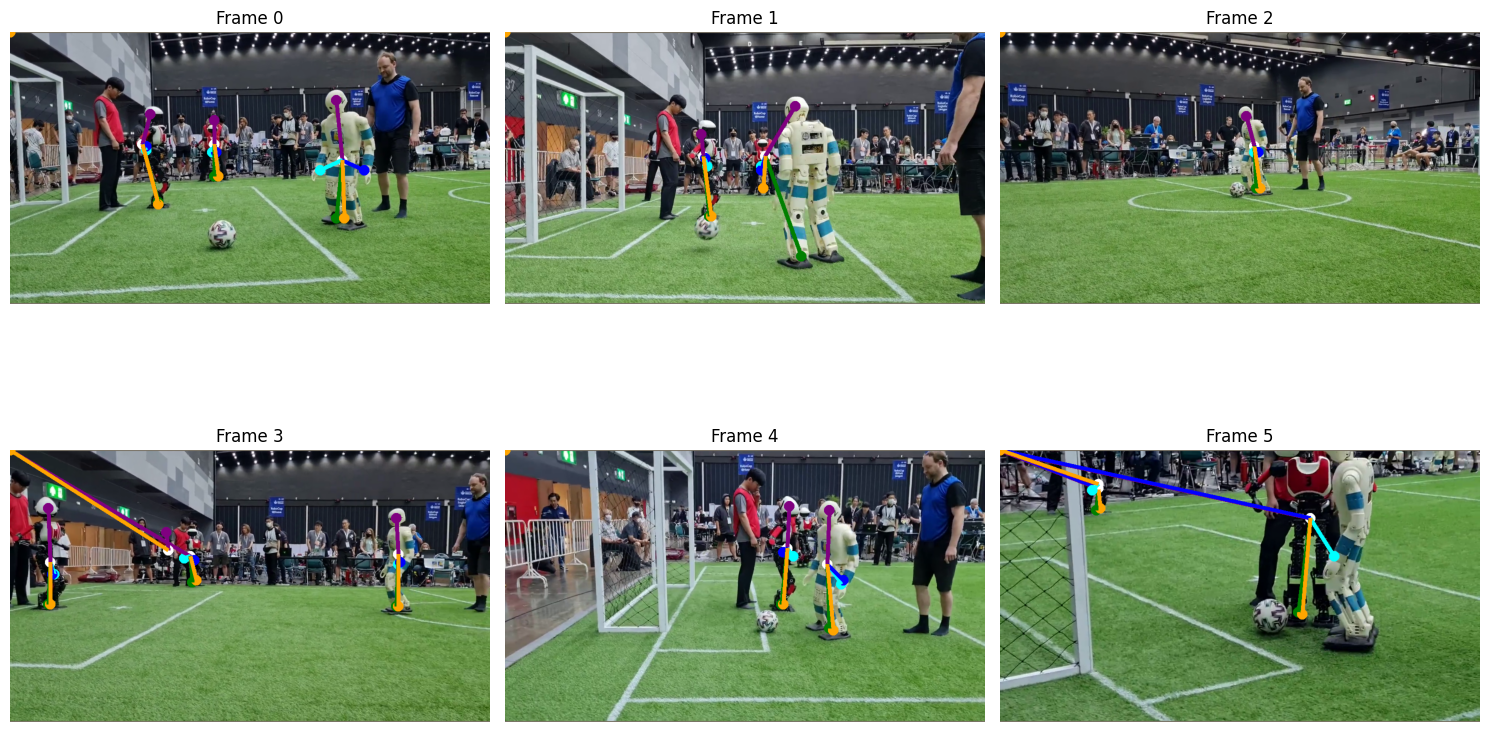

In [64]:
pose_imgs = visualizations.visualize_poses(
    unnorm_imgs,
    results * 4,
    connectivity=np.array(PoseDataset.LIMBS)
)
_ = visualizations.visualize_sequence(pose_imgs, n_cols=3, size=5)